# Bearbeitung der Feinstaubwerte für Heilbronn

### Module importieren

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

sns.set(color_codes=True)

%config InlineBackend.figure_format = 'retina'

### Daten einlesen und Datum formatieren

In [2]:
df = pd.read_csv('./sensoren_HN.csv')

In [3]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
#df.date = df.date.apply(lambda x: x + pd.DateOffset(hours=1))

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748343 entries, 0 to 748342
Data columns (total 5 columns):
dataset_id    748343 non-null int64
p10           748343 non-null float64
p25           748343 non-null float64
sensor        748343 non-null int64
date          748343 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 28.5 MB


,dataset_id,p10,p25,sensor,date
0,342413865,3.33,3.13,998,2017-09-21 15:36:05
1,342413911,4.17,3.87,1016,2017-09-21 15:36:07
2,342414749,2.63,2.50,1172,2017-09-21 15:36:37
3,342438585,3.70,3.50,4063,2017-09-21 15:50:52
4,342448740,3.60,2.70,4609,2017-09-21 15:56:56


Offizielle Messstation entfernen. Außerdem hat der Sensor 5624 den ganzen Winter über absurd hohe Werte angezeigt. Der Sensor stammt nicht von uns, irgendetwas stimmt damit offenbar nicht. Auch ihn nehmen wir raus aus der Analyse.

In [5]:
df = df[(df.sensor != 999999) & (df.sensor != 5624)]

### Daten von Silvester extrahieren

In [6]:
silvester = df[(df.date >= '2017-12-31 12:00:00') & (df.date <= '2018-01-01 12:00:00')]

Den Sensoren die passenden Geokoordinaten zuordnen

In [7]:
latlon = pd.read_csv('./sensoren.csv')

In [8]:
silv_latlon = silvester.merge(latlon, on='sensor')

In [9]:
silv_latlon = silv_latlon.drop(['orient','height','typ'], axis=1)

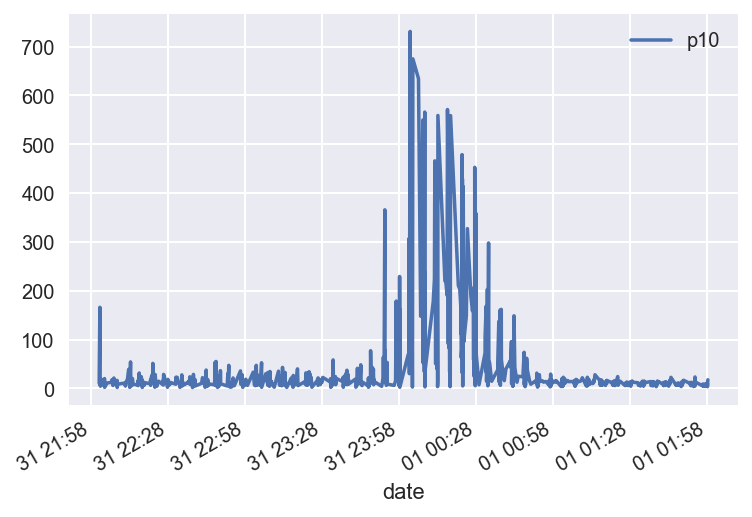

In [11]:
silv_latlon[(silv_latlon.date >= '2017-12-31 22:00:00') & (silv_latlon.date <= '2018-01-01 02:00:00')].plot(x='date',y='p10')

In [13]:
silv_latlon.to_csv('./silvester.csv', encoding='utf-8')

### Daten der Holzöfen

In [26]:
df['tag'] = df.date.dt.date
df['week'] = df.date.dt.week
df['dayofweek'] = df.date.dt.dayofweek

df['tag'] = pd.to_datetime(df['tag'], format='%Y-%m-%d')

In [27]:
df.head()

,dataset_id,p10,p25,sensor,date,tag,week,dayofweek
0,342413865,3.33,3.13,998,2017-09-21 15:36:05,2017-09-21,38,3
1,342413911,4.17,3.87,1016,2017-09-21 15:36:07,2017-09-21,38,3
2,342414749,2.63,2.50,1172,2017-09-21 15:36:37,2017-09-21,38,3
3,342438585,3.70,3.50,4063,2017-09-21 15:50:52,2017-09-21,38,3
4,342448740,3.60,2.70,4609,2017-09-21 15:56:56,2017-09-21,38,3


In [42]:
def get_weekdays(df,week,sensor):
    if (sensor == 1):
        sensor = 6866
    else:
        sensor = 7947
    df = df[df.week == week]
    df = df[df.sensor == sensor]
    df = df.groupby(['sensor','week','dayofweek','tag']).resample('H', on='date').mean().drop(['dataset_id','sensor','week','dayofweek'], axis=1).reset_index()
    for tag in df.tag.unique():
        day = df[df.tag == tag]
        day.head()
        day.plot(x='date',y='p10', title=tag,ylim=[0,100])

Mit dieser Funktion lassen sich die Daten der beiden Sensoren in Wohngebieten für jeden Tag einer bestimmten Woche darstellen. Die Sensoren 6866 (Böckingen Nord) und 7947 (Frankenbach) hingen in ruhigen Wohngebieten, in denen viele Holzöfen betrieben werden. Der folgende Befehl spuckt die Werte in Frankenbach für die Kalenderwoche 7/2018 aus.

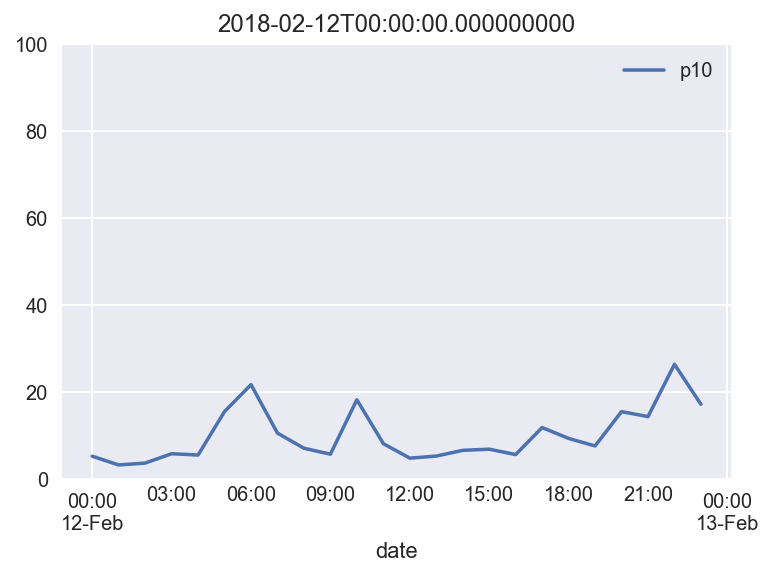

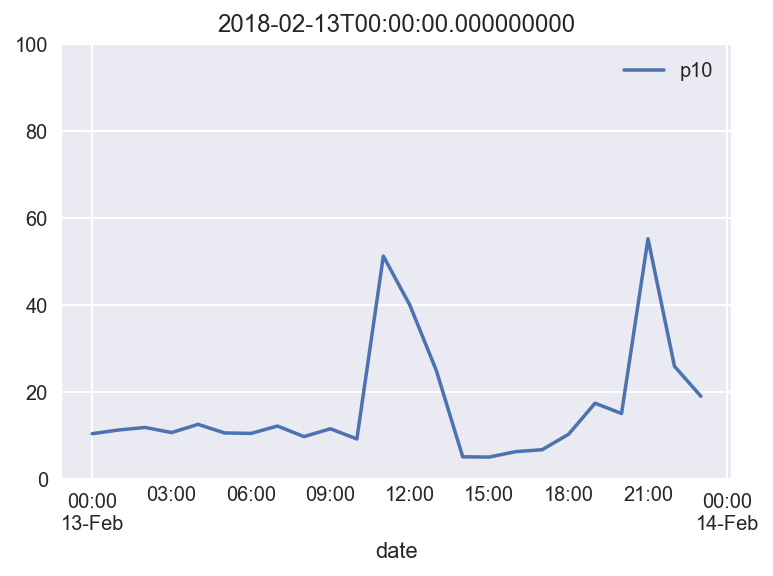

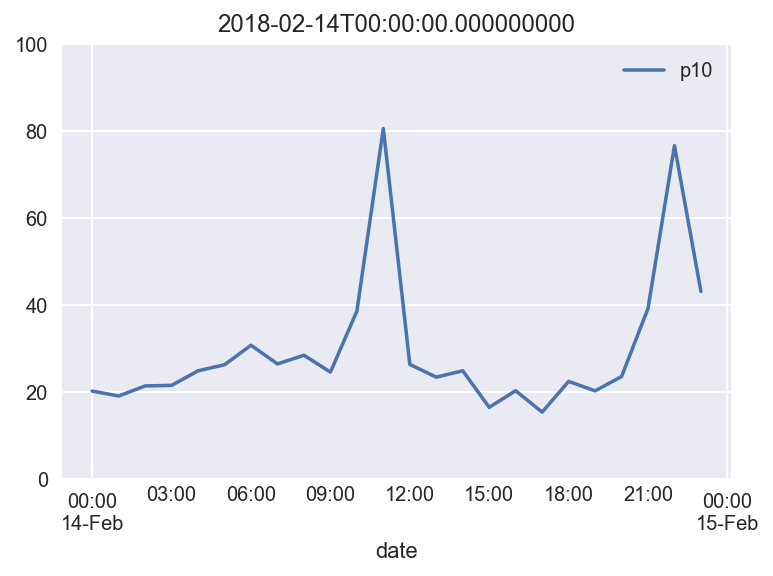

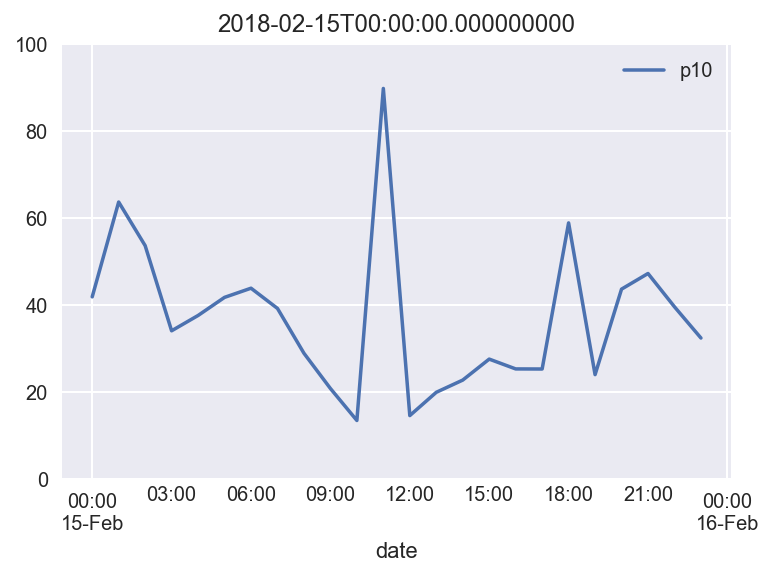

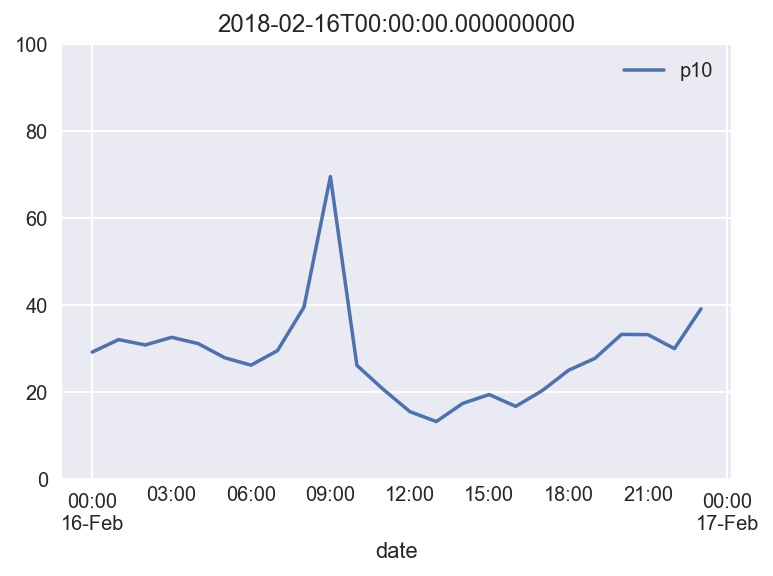

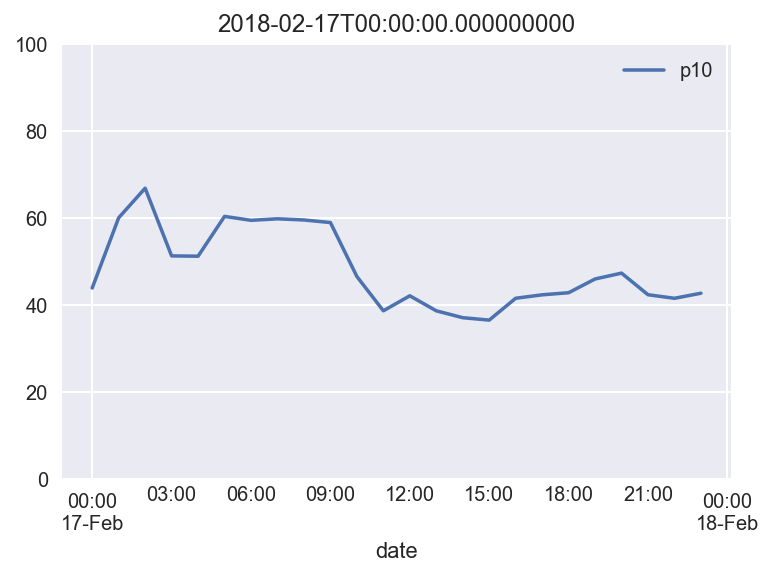

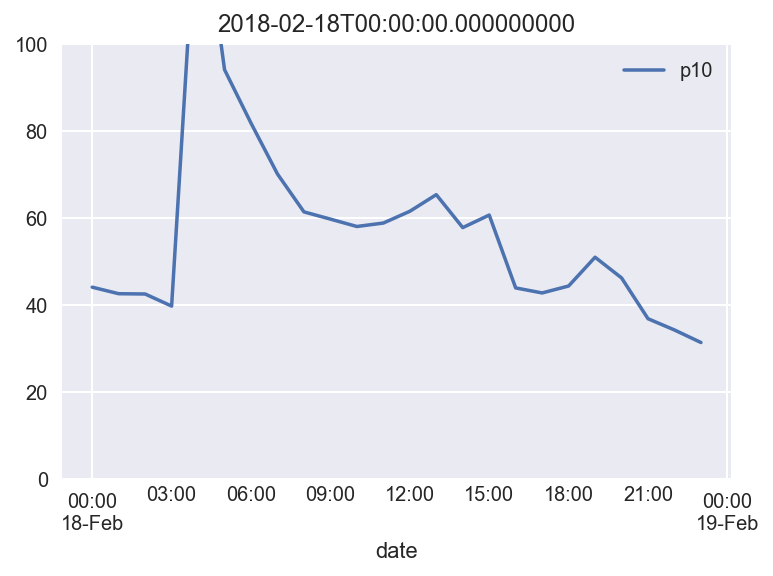

In [43]:
get_weekdays(df,7,2)

In [46]:
ofen = df[(df.tag == '2018-02-14') & (df.sensor == 7947)]

In [48]:
ofen = ofen.groupby(['sensor','week','dayofweek','tag']).resample('H', on='date').mean().drop(['dataset_id','sensor','week','dayofweek'], axis=1).reset_index()

In [49]:
ofen.to_csv('ofen.csv', index=False, encoding='utf-8')

### Die verkehrsreichen Ecken

Der Sensor 5626 (Oststraße) und der Sensor 6657 (Rathenauplatz) hängen an Stellen mit sehr viel Verkehr.

In [50]:
verkehr = df[df.sensor.isin([5626,6657])]

In [53]:
verkehr_hour = verkehr.groupby(['sensor']).resample('H', on='date').mean().drop(['dataset_id','sensor'], axis=1).reset_index()
verkehr_day = verkehr.groupby(['sensor']).resample('d', on='date').mean().drop(['dataset_id','sensor'], axis=1).reset_index()
verkehr_week = verkehr.groupby(['sensor']).resample('w', on='date').mean().drop(['dataset_id','sensor'], axis=1).reset_index()
verkehr_month = verkehr.groupby(['sensor']).resample('m', on='date').mean().drop(['dataset_id','sensor'], axis=1).reset_index()

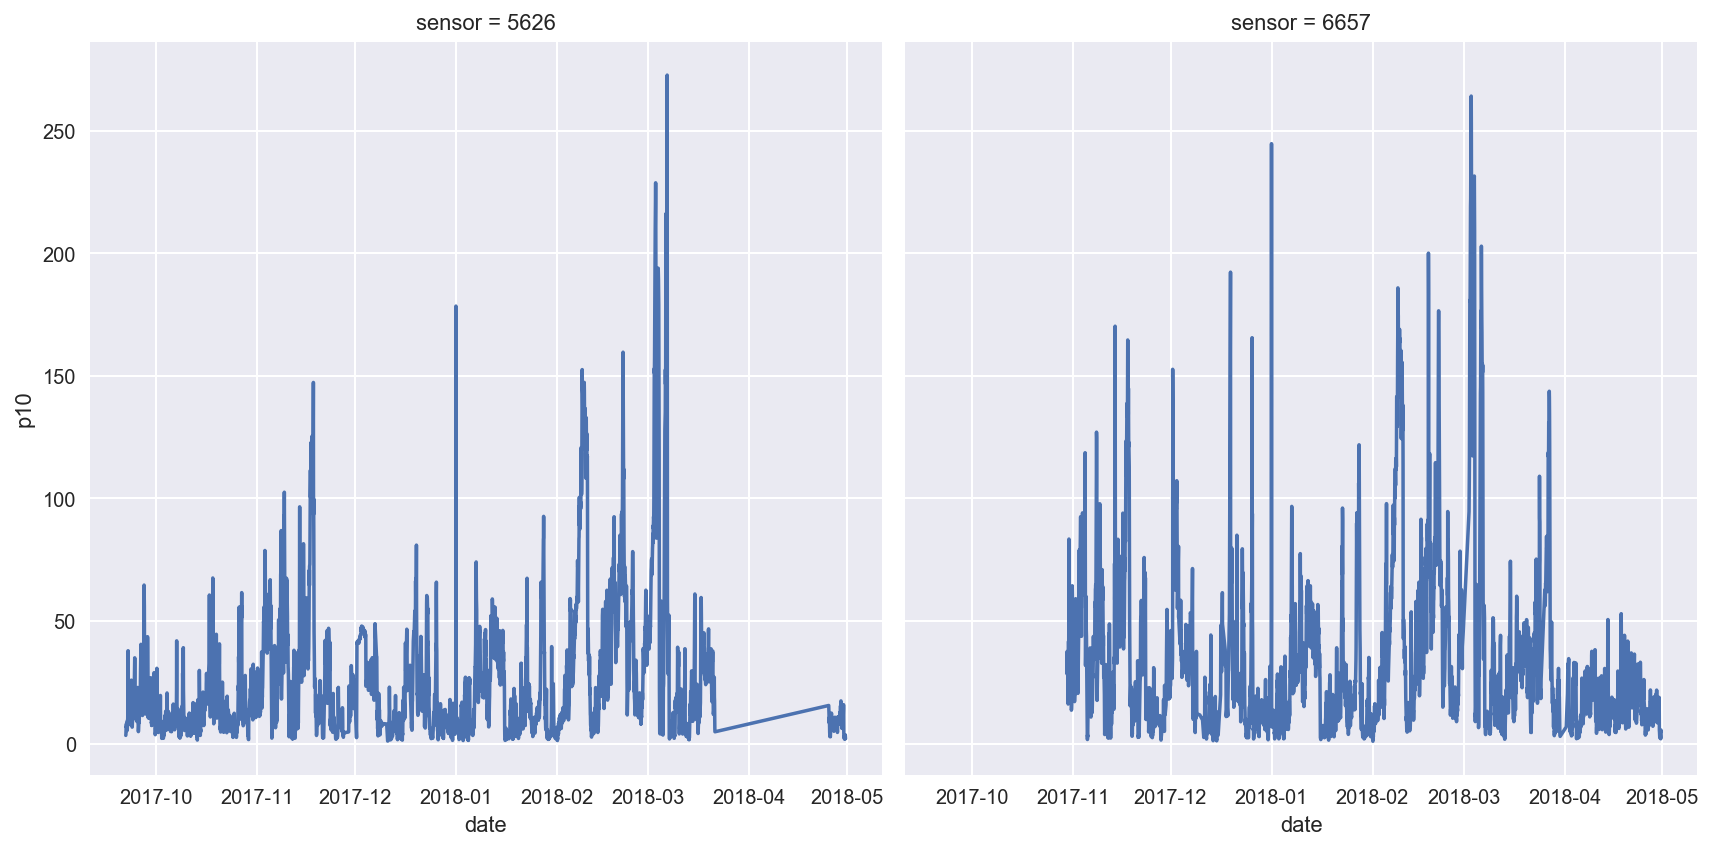

In [54]:
g = sns.FacetGrid(verkehr_hour, col="sensor", col_wrap=2,size=6)
g = g.map(plt.plot, 'date','p10')

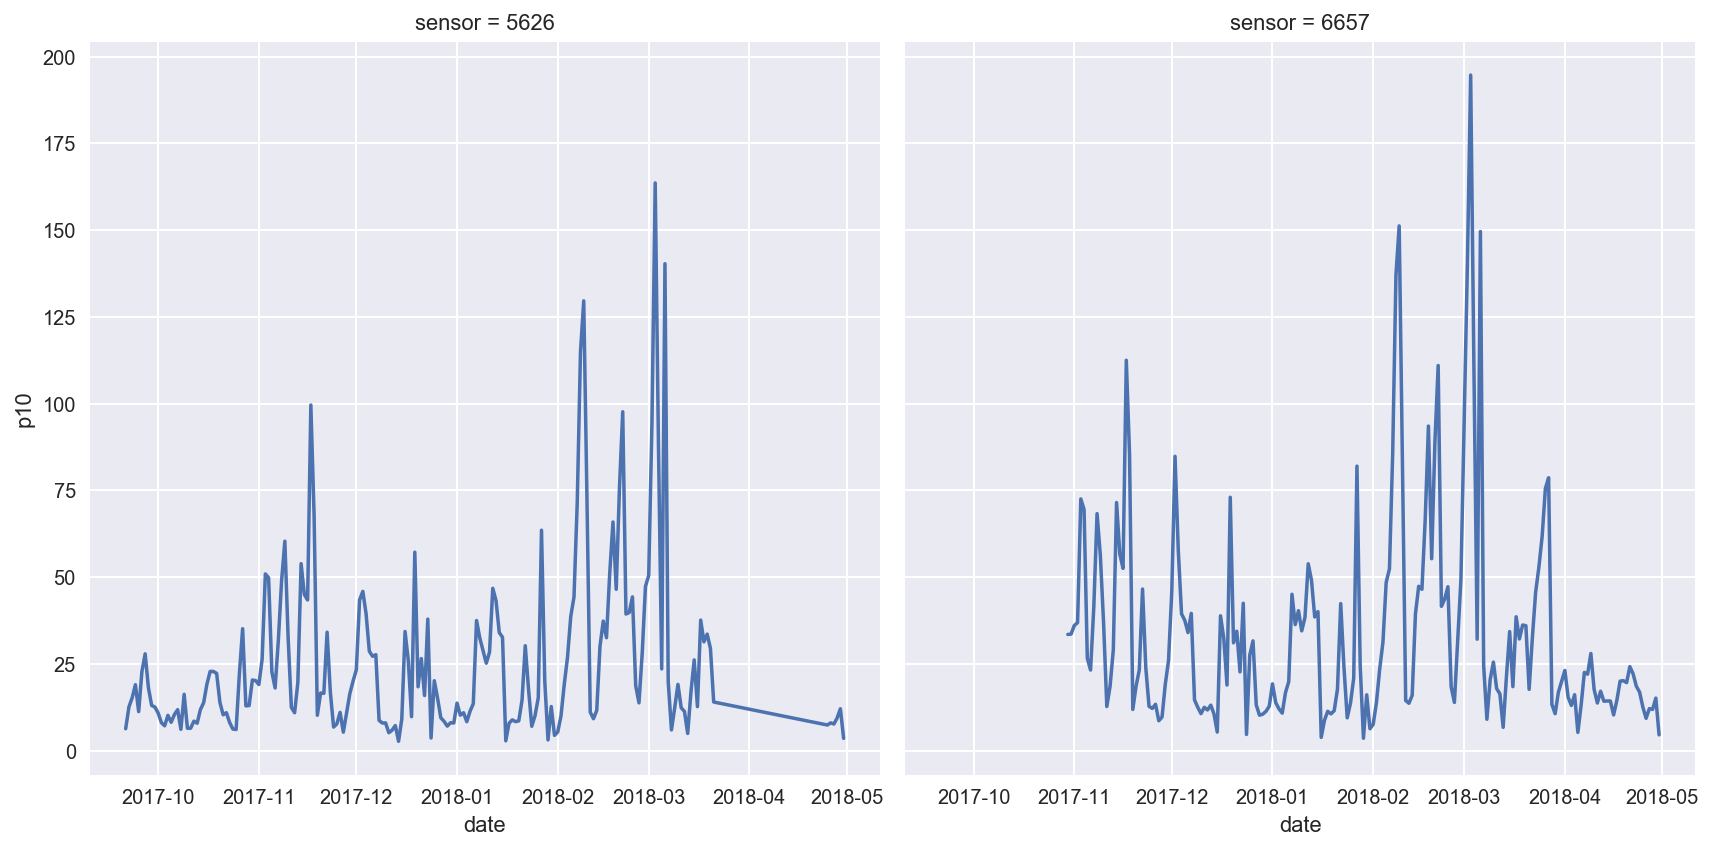

In [55]:
g = sns.FacetGrid(verkehr_day, col="sensor", col_wrap=2,size=6)
g = g.map(plt.plot, 'date','p10')

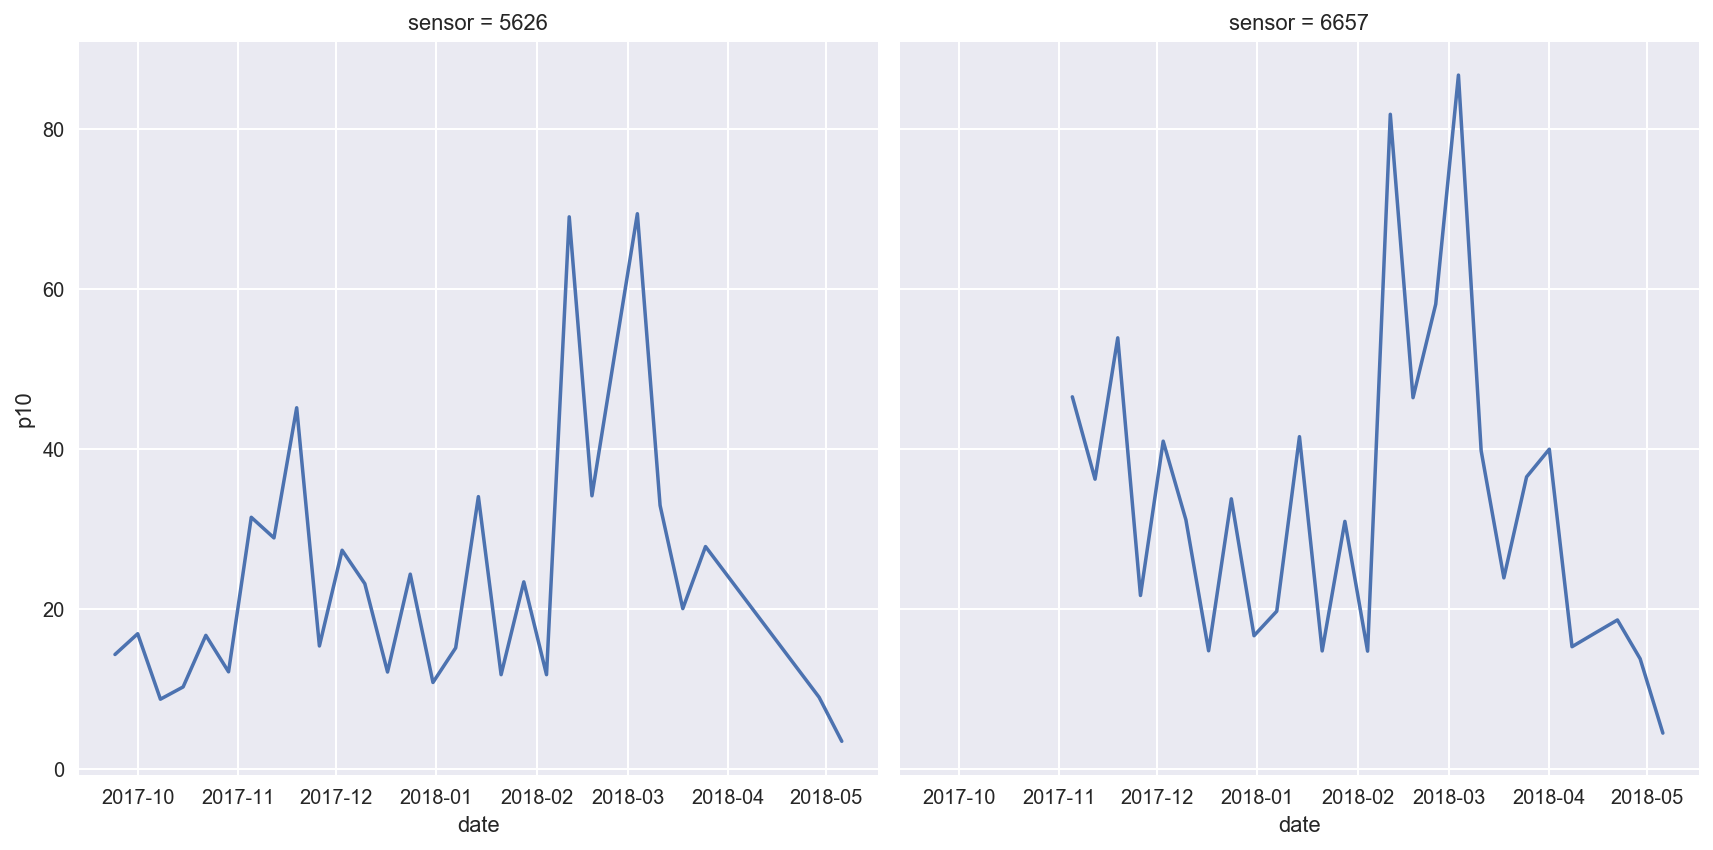

In [56]:
g = sns.FacetGrid(verkehr_week, col="sensor", col_wrap=2,size=6)
g = g.map(plt.plot, 'date','p10')

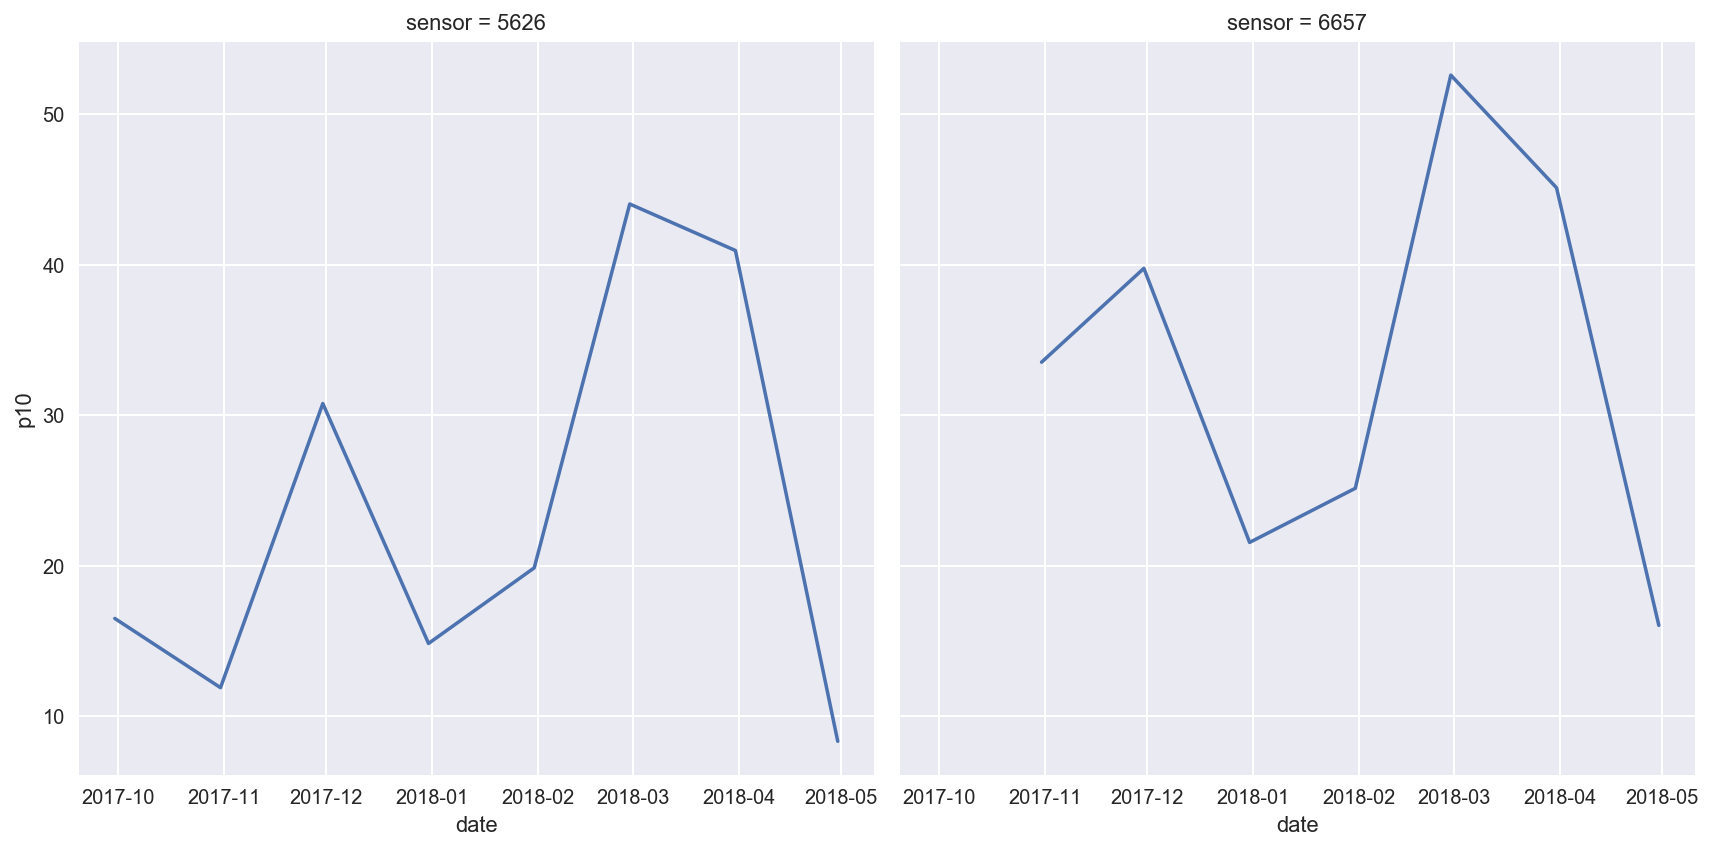

In [57]:
g = sns.FacetGrid(verkehr_month, col="sensor", col_wrap=2,size=6)
g = g.map(plt.plot, 'date','p10')

Die Tage 3. März, 6. März und 9. Februar stechen besonders hervor. Was ist an diesen Tagen passiert? Laut DWD hängen die hohen Werte wohl mit dem Wetter zusammen. 

Wie verhalten sich die beiden Sensoren im Vergleich mit den anderen Sensoren?

In [58]:
alle_day = df.groupby(['sensor']).resample('d', on='date').mean().drop(['dataset_id','sensor'], axis=1).reset_index()

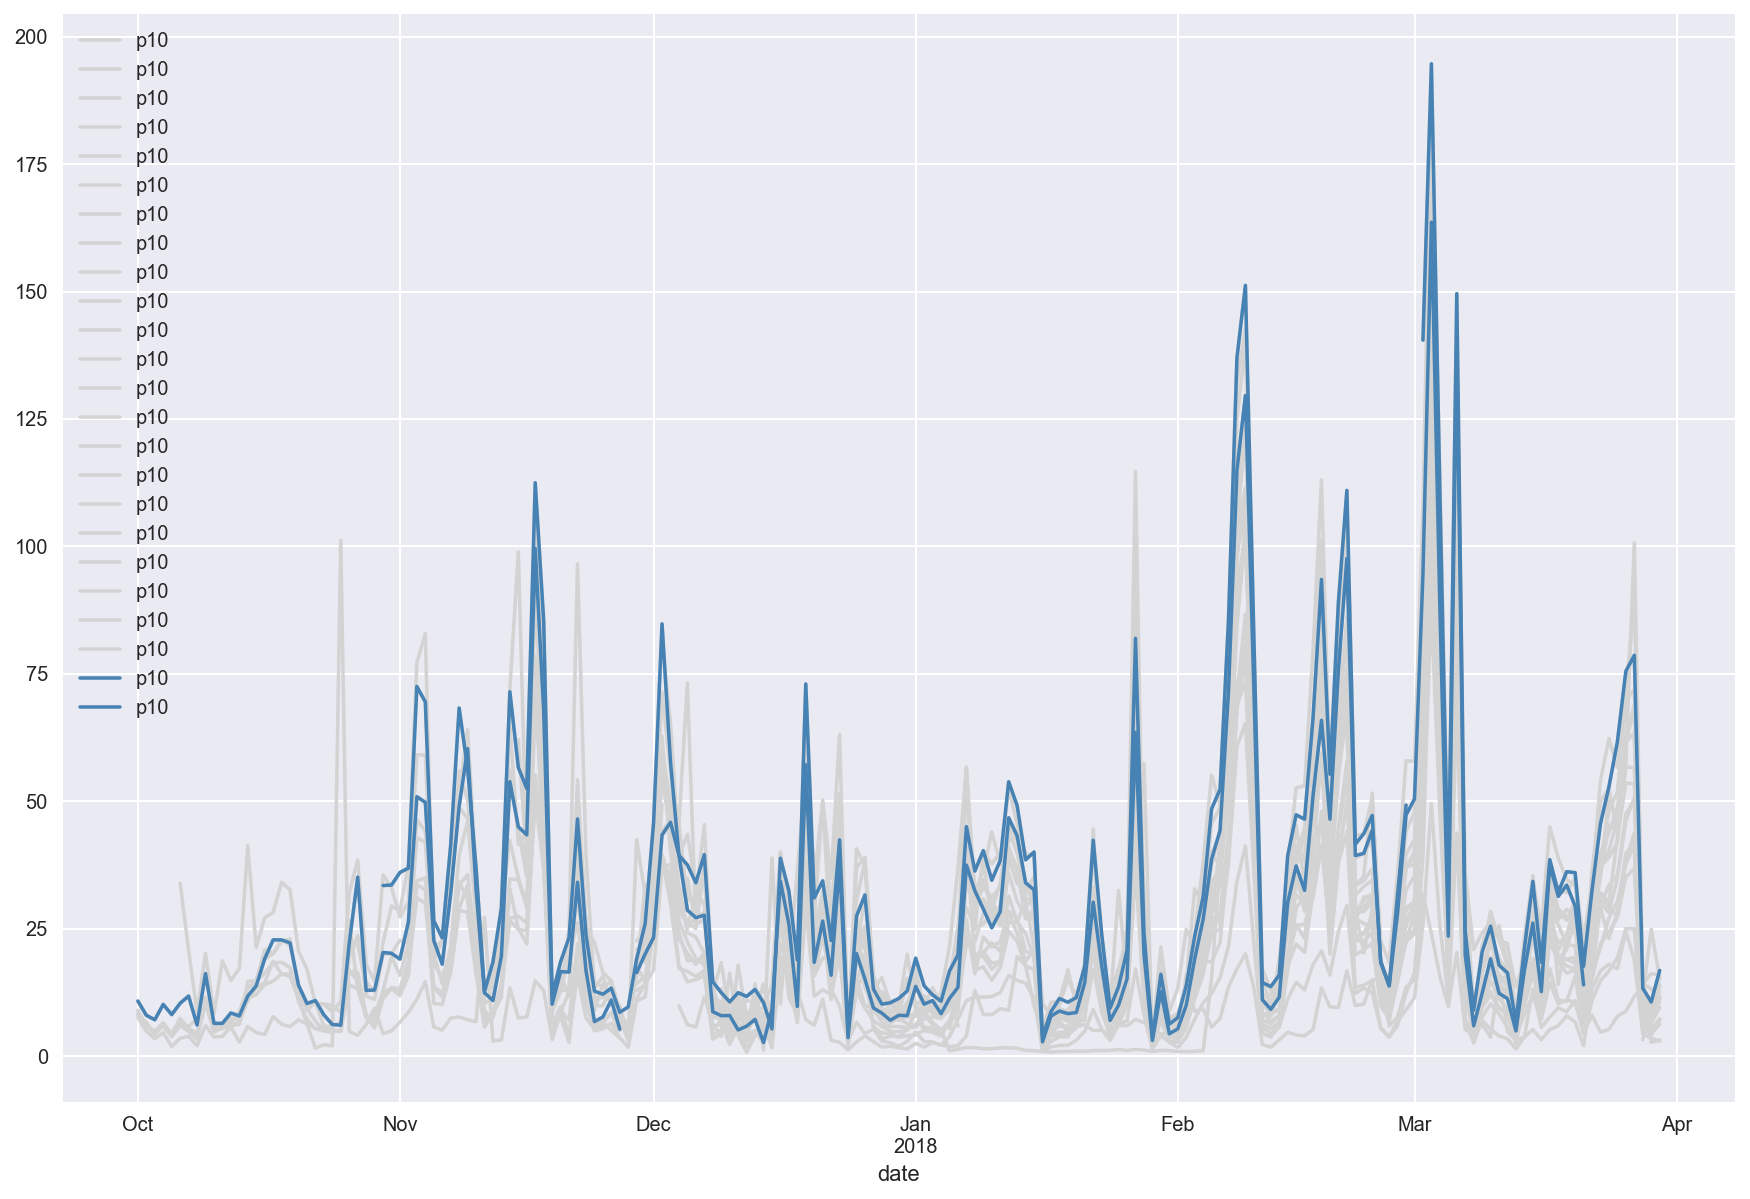

In [59]:
fig, ax = plt.subplots()
    
for key, grp in alle_day[(alle_day.date >= '2017-10-01') & (alle_day.date <= '2018-03-31')].groupby(['sensor']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='p10', c='lightgrey', figsize=[15,10])

for key, grp in verkehr_day[(verkehr_day.date >= '2017-10-01') & (verkehr_day.date <= '2018-03-31')].groupby(['sensor']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='p10', c='steelblue', figsize=[15,10])
        
#plt.show()
plt.savefig('linechart.pdf')

### Darstellung der Wochenverläufe

In [60]:
day = df.groupby(['sensor']).resample('d', on='date').mean().drop(['dataset_id','sensor'], axis=1).reset_index()

In [62]:
day['week'] = day.date.dt.week

Die folgende Schleife spuckt die Verläufe aller Kalenderwochen mit den Tagesmittelwerten aller Sensoren aus. Sie sollte je nach RAM-Größe nicht auf den kompletten Dataframe day angewendet werden. Ggf. sollte man vorher bestimmte Zeitbereiche filtern. Zum Beispiel mit folgendem Befehl:

jan = day[(day.date >= '2018-01-01') & (day.date <= '2018-01-31')]

for week in day.week.unique() muss dann natürlich entsprechend angepasst werden.

In [ ]:
for week in day.week.unique():
    
    print(week)

    fig, ax = plt.subplots()
    
    for key, grp in day[day.week == week].groupby(['sensor']):
        ax = grp.plot(ax=ax, kind='line', x='date', y='p10', c='green', figsize=[15,10])
    
    plt.show()